# Base DL models

## 0. Import library

In [1]:
# Basic
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
pd.options.display.float_format = "{:,.4f}".format
import gc

import warnings;
warnings.filterwarnings('ignore')

In [2]:
# model
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score


In [3]:
# deep learning algo
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras import backend
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Fixing the seed for random number generators
tf.random.set_seed(42)

# keras tuner
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
# keras tuner
# !pip install keras-tuner --upgrade
from kerastuner.tuners import RandomSearch

## 1. Import data

In [5]:
df = pd.read_csv('reviews_cleaned.csv', parse_dates=['timestamp_created'])

In [6]:
df.head()

,recommendationid,review,timestamp_created,voted_up
0,132354840,loe love love game purchased sale would recomm...,2023-02-07,True
1,132354176,fun,2023-02-07,True
2,132353890,full gen z game,2023-02-07,False
3,132353500,good,2023-02-07,True
4,132352818,captivating like movie,2023-02-07,True


In [7]:
 df['voted_up'].value_counts(), df['voted_up'].value_counts(normalize = True)

(True     304152
 False    158426
 Name: voted_up, dtype: int64,
 True    0.6575
 False   0.3425
 Name: voted_up, dtype: float64)

## 2. Preprocess

### Exclude 5% of the most recent reviews for holdout set

<Axes: xlabel='timestamp_created', ylabel='Count'>

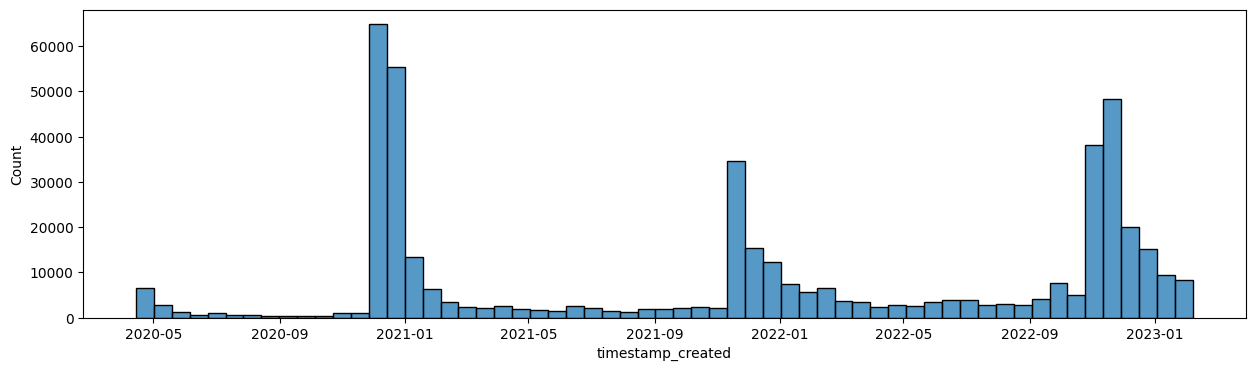

In [8]:
plt.figure(figsize=(15,4))
sns.histplot(x=df.timestamp_created)

In [9]:
# date of 95th quantile reviews
df.timestamp_created.quantile(0.95)

Timestamp('2022-12-28 00:00:00')

In [10]:
%%time
X = df['review']

X_holdout = X[df.timestamp_created >= df.timestamp_created.quantile(0.95)]
X = X[df.timestamp_created < df.timestamp_created.quantile(0.95)]

X

CPU times: total: 15.6 ms
Wall time: 17 ms


6282           great game might update gpu make work better
6283      theyve fixed game pretty well couple bug encou...
6284                           cuz really wanna stay housee
6285                               finally game story great
6286                                               bee knee
                                ...                        
462573      game wajib untuk budak ea sungkem yang mulia ea
462574    lot change fifa afterall finally good feeling ...
462575    first time played ultimate team got honest tot...
462576    loved game much waiting fifa 22 since august w...
462577                                fifa nothing else say
Name: review, Length: 439032, dtype: object

In [11]:
y = df['voted_up'][df.timestamp_created < df.timestamp_created.quantile(0.95)]
y_holdout = df['voted_up'][df.timestamp_created >= df.timestamp_created.quantile(0.95)]

### Bag of words

In [12]:
def bow_vectorizer(X_train, X_test, n_features):
    vectorizer = CountVectorizer(max_features = n_features, dtype = np.uint8)
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    
    # X_train = pd.DataFrame(X_train.toarray(), columns = vectorizer.get_feature_names_out())
    # X_test = pd.DataFrame(X_test.toarray(), columns = vectorizer.get_feature_names_out())
    return X_train, X_test

### TF IDF

In [13]:
def tfidf_vectorizer(X_train, X_test, n_features):
    vectorizer = TfidfVectorizer(max_features = n_features)
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    # X_train = pd.DataFrame(X_train.toarray(), columns = vectorizer.get_feature_names_out())
    # X_test = pd.DataFrame(X_test.toarray(), columns = vectorizer.get_feature_names_out())

    return X_train, X_test

### TF IDF with bigram

In [14]:
def tfidf2g_vectorizer(X_train, X_test, n_features):
    vectorizer = TfidfVectorizer(max_features = n_features, ngram_range=(1,2))
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    # X_train = pd.DataFrame(X_train.toarray(), columns = vectorizer.get_feature_names_out())
    # X_test = pd.DataFrame(X_test.toarray(), columns = vectorizer.get_feature_names_out())

    return X_train, X_test

## 3. DL base models

As seen in the preliminary run, DL model with 4 layers and 2000 features performs slightly better than the 3 layer model and/or less feature. The choice for feature engineering doesn't seem to affect much. Let's see if there's a difference for full data.

### Function for metrics

In [15]:
columns = ['model name', 'data', 'time', 
           'train_down_Pre',
           'train_down_Rec',
           'train_down_F1',
           'train_up_Pre',
           'train_up_Rec',
           'train_up_F1',
           'train_acc',
           'test_down_Pre',
           'test_down_Rec',
           'test_down_F1',
           'test_up_Pre',
           'test_up_Rec',
           'test_up_F1',
           'test_acc']
           
df_metrics = pd.DataFrame(columns = columns)

In [16]:
def reset(df_metrics):
    return pd.DataFrame(columns = columns)

In [17]:
def dl_performance(model_name, model, X_name, X_train, X_test, y_train, y_test, complete_time = 0, threshold = 0.5): #, X_train, X_test, y_train, y_test):
    
    #print('Training: ', model_name, '/', X_name)
    y_hat_train = np.where(model.predict(X_train) > threshold,1,0)
    y_hat_test = np.where(model.predict(X_test) > threshold,1,0)
    
    
    # Train ##############
    # accuracy
    accuracy_train = accuracy_score(y_train, y_hat_train)
    # pre/rec/f1 for True
    precision_train_True = precision_score(y_train, y_hat_train, pos_label = True)
    recall_train_True = recall_score(y_train, y_hat_train, pos_label = True)
    F1_train_True = f1_score(y_train, y_hat_train, pos_label = True)
    
    # pre/rec/f1 for false
    precision_train_False = precision_score(y_train, y_hat_train, pos_label = False)
    recall_train_False = recall_score(y_train, y_hat_train, pos_label = False)
    F1_train_False = f1_score(y_train, y_hat_train, pos_label = False)
    
    # Test ##############
    # accuracy
    accuracy_test = accuracy_score(y_test, y_hat_test)
    # pre/rec/f1 for True
    precision_test_True = precision_score(y_test, y_hat_test, pos_label = True)
    recall_test_True = recall_score(y_test, y_hat_test, pos_label = True)
    F1_test_True = f1_score(y_test, y_hat_test, pos_label = True)

    # pre/rec/f1 for false
    precision_test_False = precision_score(y_test, y_hat_test, pos_label = False)
    recall_test_False = recall_score(y_test, y_hat_test, pos_label = False)
    F1_test_False = f1_score(y_test, y_hat_test, pos_label = False)

    # store result
    df_metrics.loc[len(df_metrics.index)] = [
        model_name, X_name, complete_time, 
        precision_train_False, recall_train_False, F1_train_False,
        precision_train_True,  recall_train_True,  F1_train_True, accuracy_train,
        precision_test_False,  recall_test_False,  F1_test_False, 
        precision_test_True,   recall_test_True,   F1_test_True, accuracy_test]
    
    print('Train')
    print(classification_report(y_train, y_hat_train))
    print('Test')
    print(classification_report(y_test, y_hat_test))

    fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(6,3))
    labels = ['Negative', 'Positive']

    sns.heatmap(confusion_matrix(y_train, y_hat_train), annot=True, ax=ax1, 
                cbar=False, xticklabels=labels, yticklabels=labels, fmt='.0f')
    sns.heatmap(confusion_matrix(y_test, y_hat_test), annot=True, ax=ax2, 
                cbar=False, xticklabels=labels, yticklabels=labels, fmt='.0f')
    ax1.set(ylabel='Actual', xlabel='Predicted') 
    ax2.set(ylabel='Actual', xlabel='Predicted')
    plt.tight_layout()
    plt.show()
    print('Finished in',complete_time)
    print('='*50)
    return df_metrics.loc[len(df_metrics.index)-1]

In [18]:
def accuracy_vs_epochs(history, from_epoc=0):
    df_history = pd.DataFrame(history.history).iloc[from_epoc:]
    plt.figure(figsize = (4,2))
    plt.plot(df_history.iloc[:,1])
    plt.plot(df_history.iloc[:,3])
    plt.xlim(left=-1)
    plt.title(str(df_history.columns[1]) +  ' vs epochs')
    plt.ylabel(df_history.columns[1])
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    plt.show()

In [19]:
def DL_model_fit(model_name, model, callback, X_name, X_train_vectorized, X_test_vectorized, y_train, y_test):    
    print(f'Training:  {model_name} / {X_name}')
    start = time.time()
    backend.clear_session()
    
    X_train_vectorized = X_train_vectorized.toarray()
    X_test_vectorized = X_test_vectorized.toarray()
    
    history = model.fit(X_train_vectorized, y_train, 
                        batch_size=32,
                        epochs=10,
                        callbacks=[callback],
                        verbose=1,
                        validation_split = 0.1)
    completion_time = round(time.time() - start,2)
    accuracy_vs_epochs(history)
    dl_performance(model_name, model, X_name, X_train_vectorized, X_test_vectorized, y_train, y_test, completion_time)

### DL model list

In [20]:
# function to create DL model
def make_DL_model(neuron_list, dropout_list, input_dim, metric=tf.keras.metrics.AUC()):
    
    model = Sequential()
    model.add(Dense(neuron_list[0], activation='relu',kernel_initializer='he_uniform',input_dim = input_dim))
    model.add(Dropout(dropout_list[0]))
    
    for neuron, dropout in zip(neuron_list[1:], dropout_list[1:]):
        model.add(Dense(neuron,activation='relu',kernel_initializer='he_uniform'))
        model.add(Dropout(dropout))
   
    # Output layer
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(0.001), metrics=metric)
    return model

In [21]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

### Loops

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2, random_state=14)

X_train_bow_2000    , X_test_bow_2000     = bow_vectorizer(X_train, X_test, 2000)
X_train_tfidf_2000  , X_test_tfidf_2000   = tfidf_vectorizer(X_train, X_test, 2000)
X_train_tfidf2g_2000, X_test_tfidf2g_2000 = tfidf2g_vectorizer(X_train, X_test, 2000)

In [23]:
DL_4layer_model_bow     = make_DL_model((256,128,64,32), (0.5,0.5,0.3,0.2), input_dim = 2000, metric='accuracy')
DL_4layer_model_tfidf   = make_DL_model((256,128,64,32), (0.5,0.5,0.3,0.2), input_dim = 2000, metric='accuracy')
DL_4layer_model_tfidf2g = make_DL_model((256,128,64,32), (0.5,0.5,0.3,0.2), input_dim = 2000, metric='accuracy')

In [24]:
model_data_list = [
    ('DL_4layer_model_bow'    , DL_4layer_model_bow    , 'bow'    , X_train_bow_2000    , X_test_bow_2000),
    ('DL_4layer_model_tfidf'  , DL_4layer_model_tfidf  , 'tfidf'  , X_train_tfidf_2000  , X_test_tfidf_2000),
    ('DL_4layer_model_tfidf2g', DL_4layer_model_tfidf2g, 'tfidf2g', X_train_tfidf2g_2000, X_test_tfidf2g_2000)
]

Loop the 4 layer model through 3 different train set

Training:  DL_4layer_model_bow / bow
Epoch 1/10
9879/9879 [==============================] - 32s 3ms/step - loss: 0.3629 - accuracy: 0.8503 - val_loss: 0.3281 - val_accuracy: 0.8639
Epoch 2/10
9879/9879 [==============================] - 30s 3ms/step - loss: 0.3252 - accuracy: 0.8679 - val_loss: 0.3198 - val_accuracy: 0.8690
Epoch 3/10
9879/9879 [==============================] - 30s 3ms/step - loss: 0.3091 - accuracy: 0.8754 - val_loss: 0.3184 - val_accuracy: 0.8686
Epoch 4/10
9879/9879 [==============================] - 31s 3ms/step - loss: 0.2951 - accuracy: 0.8823 - val_loss: 0.3177 - val_accuracy: 0.8710
Epoch 5/10
9879/9879 [==============================] - 32s 3ms/step - loss: 0.2841 - accuracy: 0.8871 - val_loss: 0.3157 - val_accuracy: 0.8719
Epoch 6/10
9879/9879 [==============================] - 31s 3ms/step - loss: 0.2758 - accuracy: 0.8909 - val_loss: 0.3210 - val_accuracy: 0.8711
Epoch 7/10
9879/9879 [==============================] - 30s 3ms/step - loss: 0.2676 - accurac

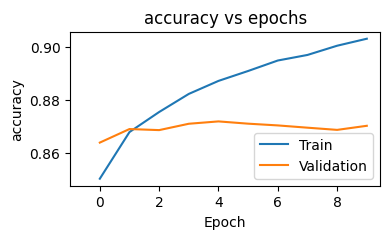

2744/2744 [==============================] - 3s 1ms/step
Train
              precision    recall  f1-score   support

       False       0.89      0.81      0.85    120213
        True       0.91      0.95      0.93    231012

    accuracy                           0.90    351225
   macro avg       0.90      0.88      0.89    351225
weighted avg       0.90      0.90      0.90    351225

Test
              precision    recall  f1-score   support

       False       0.85      0.76      0.80     30053
        True       0.88      0.93      0.90     57754

    accuracy                           0.87     87807
   macro avg       0.86      0.84      0.85     87807
weighted avg       0.87      0.87      0.87     87807



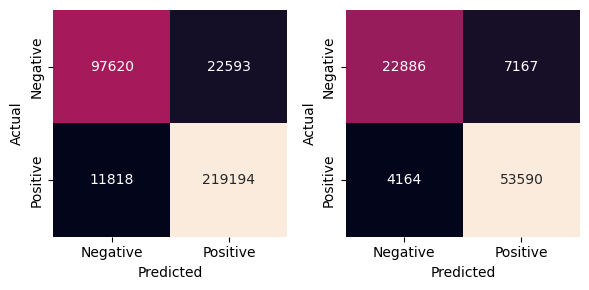

Finished in 310.99
Training:  DL_4layer_model_tfidf / tfidf
Epoch 1/10
9879/9879 [==============================] - 30s 3ms/step - loss: 0.3488 - accuracy: 0.8537 - val_loss: 0.3232 - val_accuracy: 0.8645
Epoch 2/10
9879/9879 [==============================] - 31s 3ms/step - loss: 0.3191 - accuracy: 0.8691 - val_loss: 0.3153 - val_accuracy: 0.8692
Epoch 3/10
9879/9879 [==============================] - 29s 3ms/step - loss: 0.3019 - accuracy: 0.8772 - val_loss: 0.3106 - val_accuracy: 0.8691
Epoch 4/10
9879/9879 [==============================] - 29s 3ms/step - loss: 0.2864 - accuracy: 0.8853 - val_loss: 0.3114 - val_accuracy: 0.8712
Epoch 5/10
9879/9879 [==============================] - 30s 3ms/step - loss: 0.2733 - accuracy: 0.8918 - val_loss: 0.3090 - val_accuracy: 0.8728
Epoch 6/10
9879/9879 [==============================] - 30s 3ms/step - loss: 0.2609 - accuracy: 0.8978 - val_loss: 0.3237 - val_accuracy: 0.8707
Epoch 7/10
9879/9879 [==============================] - 29s 3ms/step -

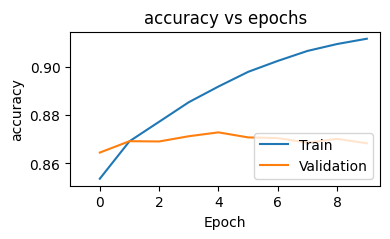

2744/2744 [==============================] - 4s 1ms/step
Train
              precision    recall  f1-score   support

       False       0.89      0.83      0.86    120213
        True       0.92      0.95      0.93    231012

    accuracy                           0.91    351225
   macro avg       0.90      0.89      0.90    351225
weighted avg       0.91      0.91      0.91    351225

Test
              precision    recall  f1-score   support

       False       0.84      0.78      0.81     30053
        True       0.89      0.92      0.90     57754

    accuracy                           0.87     87807
   macro avg       0.86      0.85      0.86     87807
weighted avg       0.87      0.87      0.87     87807



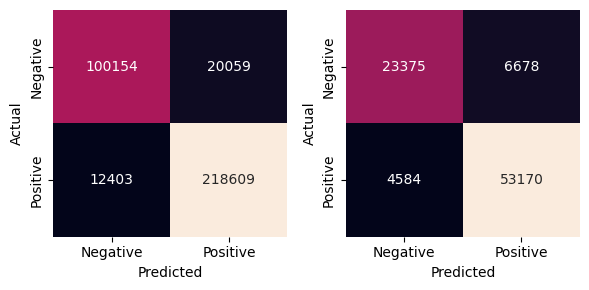

Finished in 300.87
Training:  DL_4layer_model_tfidf2g / tfidf2g
Epoch 1/10
9879/9879 [==============================] - 32s 3ms/step - loss: 0.3477 - accuracy: 0.8537 - val_loss: 0.3201 - val_accuracy: 0.8639
Epoch 2/10
9879/9879 [==============================] - 30s 3ms/step - loss: 0.3193 - accuracy: 0.8687 - val_loss: 0.3131 - val_accuracy: 0.8674
Epoch 3/10
9879/9879 [==============================] - 32s 3ms/step - loss: 0.3049 - accuracy: 0.8753 - val_loss: 0.3109 - val_accuracy: 0.8689
Epoch 4/10
9879/9879 [==============================] - 30s 3ms/step - loss: 0.2911 - accuracy: 0.8835 - val_loss: 0.3104 - val_accuracy: 0.8713
Epoch 5/10
9879/9879 [==============================] - 30s 3ms/step - loss: 0.2784 - accuracy: 0.8900 - val_loss: 0.3122 - val_accuracy: 0.8719
Epoch 6/10
9879/9879 [==============================] - 30s 3ms/step - loss: 0.2667 - accuracy: 0.8957 - val_loss: 0.3256 - val_accuracy: 0.8693
Epoch 7/10
9879/9879 [==============================] - 32s 3ms/st

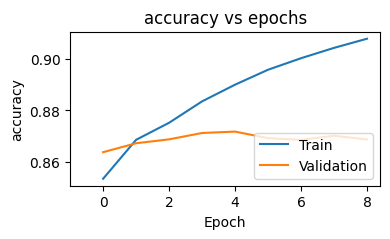

2744/2744 [==============================] - 4s 2ms/step
Train
              precision    recall  f1-score   support

       False       0.90      0.79      0.84    120213
        True       0.90      0.95      0.92    231012

    accuracy                           0.90    351225
   macro avg       0.90      0.87      0.88    351225
weighted avg       0.90      0.90      0.89    351225

Test
              precision    recall  f1-score   support

       False       0.86      0.74      0.80     30053
        True       0.88      0.94      0.90     57754

    accuracy                           0.87     87807
   macro avg       0.87      0.84      0.85     87807
weighted avg       0.87      0.87      0.87     87807



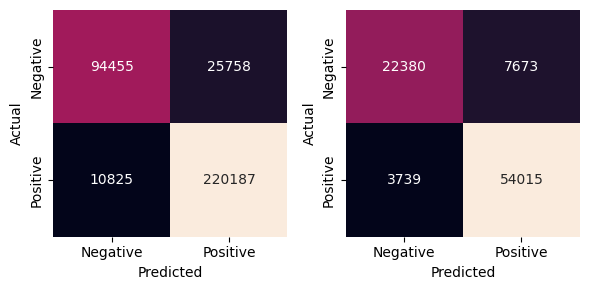

Finished in 284.01


In [25]:
for model_name, model, X_name, X_train_vectorized, X_test_vectorized in model_data_list:
    DL_model_fit(model_name, model, callback, X_name, X_train_vectorized, X_test_vectorized, y_train, y_test)

### AUC

313/313 [==============================] - 0s 985us/step


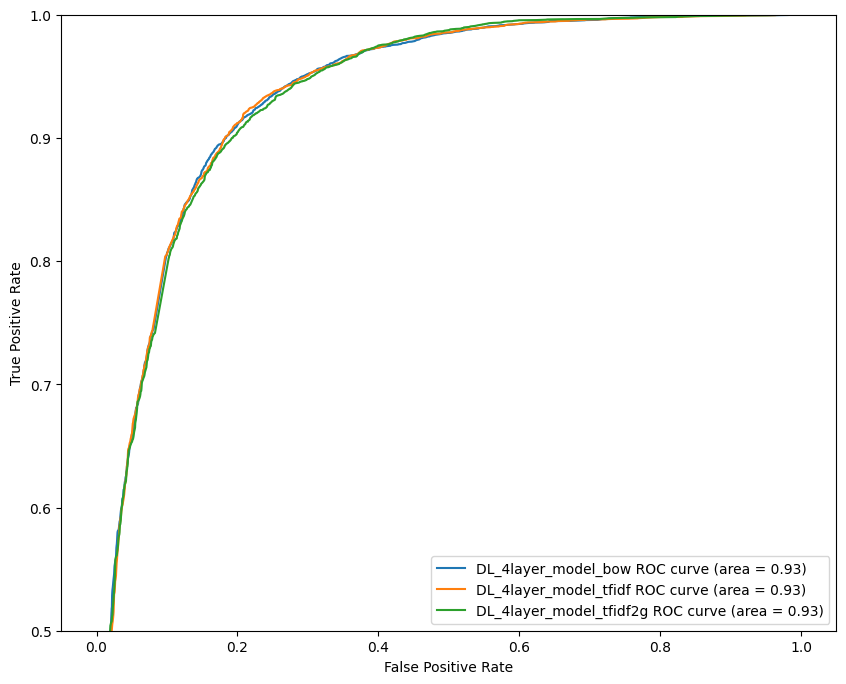

In [35]:
plt.figure(figsize=(10,8))
for model_name, model, X_name, X_train_vectorized, X_test_vectorized in model_data_list:
    yhat_proba = model.predict(X_test_vectorized.toarray()[:10000])
    fpr, tpr, _ = roc_curve(y_test[:10000],  yhat_proba)
    auc_score = roc_auc_score( y_test[:10000], yhat_proba )
    sns.lineplot(x=fpr,y=tpr, label=model_name + ' ROC curve (area = %0.2f)' % auc_score)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")
plt.ylim(0.5,1)
plt.show()    

### Precision/Recall tradeoff

In [42]:
# function to plot precision/recall curve
def pre_rec_curve(model, X_train_vectorized, threshold=0.5):
    y_proba= model.predict(X_train_vectorized.toarray())
    precisions, recalls, thresholds = precision_recall_curve(y_train, y_proba, pos_label=1)
    thresholds = np.insert(thresholds, 0, 0)
    F1_score = 2*precisions*recalls/(precisions+recalls)

    # Plot values of precisions, recalls, and thresholds
    plt.figure(figsize=(10,7))
    plt.plot(thresholds, precisions, 'b--', label='precision')
    plt.plot(thresholds, recalls, 'g--', label = 'recall')
    plt.plot(thresholds, F1_score, 'r--', label = 'f1 score')

    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    # plt.ylim([0.6,1])
    plt.axvline(threshold)
    plt.show()

10976/10976 [==============================] - 14s 1ms/step


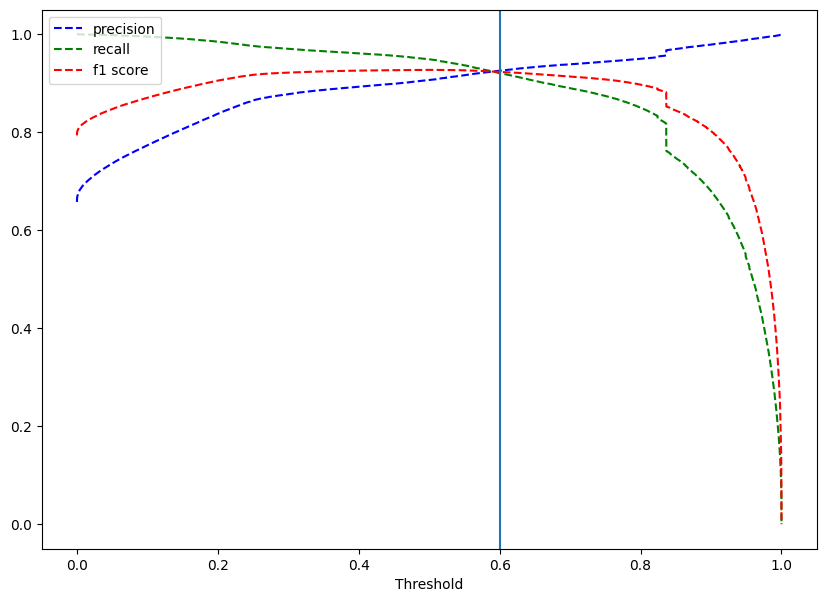

In [43]:
pre_rec_curve(DL_4layer_model_bow, X_train_bow_2000, threshold=0.6)

10976/10976 [==============================] - 14s 1ms/step


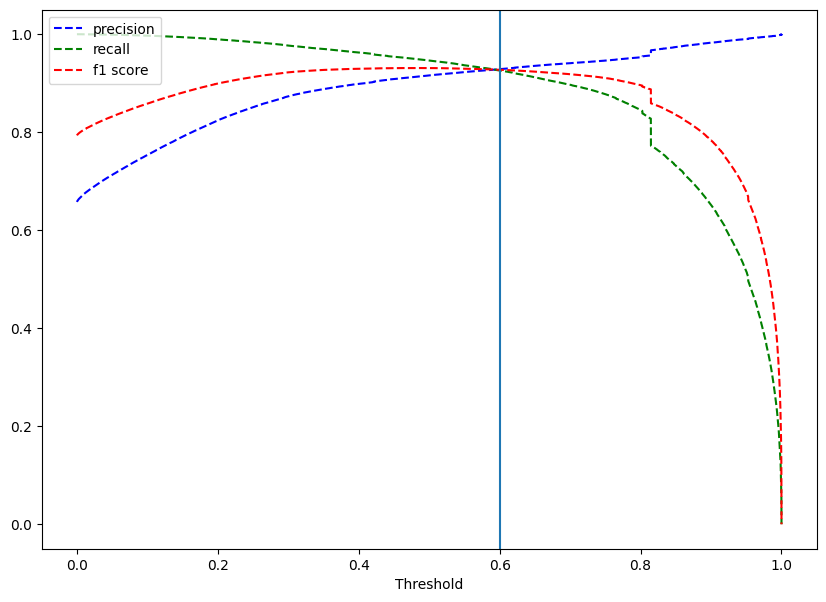

In [44]:
pre_rec_curve(DL_4layer_model_tfidf, X_train_tfidf_2000, threshold=0.6)

10976/10976 [==============================] - 14s 1ms/step


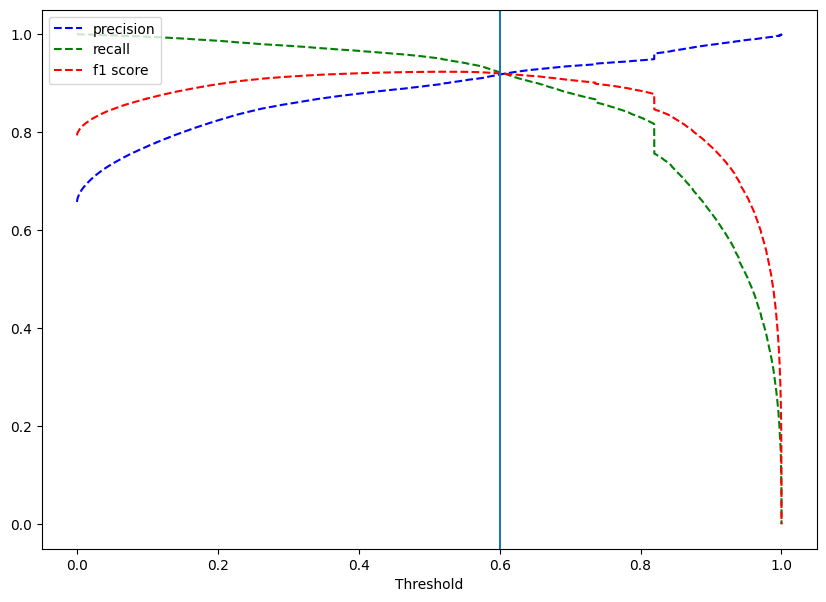

In [45]:
pre_rec_curve(DL_4layer_model_tfidf2g, X_train_tfidf2g_2000, threshold=0.6)

2744/2744 [==============================] - 3s 1ms/step
Train
              precision    recall  f1-score   support

       False       0.85      0.86      0.85    120213
        True       0.93      0.92      0.92    231012

    accuracy                           0.90    351225
   macro avg       0.89      0.89      0.89    351225
weighted avg       0.90      0.90      0.90    351225

Test
              precision    recall  f1-score   support

       False       0.80      0.81      0.81     30053
        True       0.90      0.90      0.90     57754

    accuracy                           0.87     87807
   macro avg       0.85      0.85      0.85     87807
weighted avg       0.87      0.87      0.87     87807



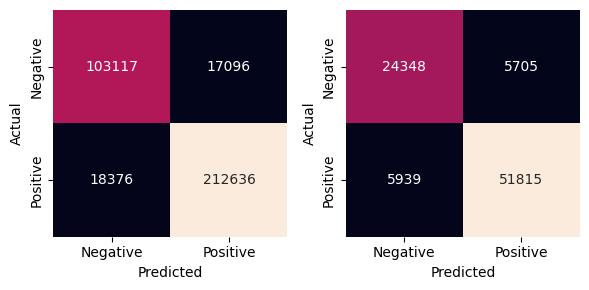

Finished in 0
2744/2744 [==============================] - 3s 1ms/step
Train
              precision    recall  f1-score   support

       False       0.86      0.86      0.86    120213
        True       0.93      0.93      0.93    231012

    accuracy                           0.90    351225
   macro avg       0.89      0.89      0.89    351225
weighted avg       0.90      0.90      0.90    351225

Test
              precision    recall  f1-score   support

       False       0.81      0.81      0.81     30053
        True       0.90      0.90      0.90     57754

    accuracy                           0.87     87807
   macro avg       0.85      0.86      0.85     87807
weighted avg       0.87      0.87      0.87     87807



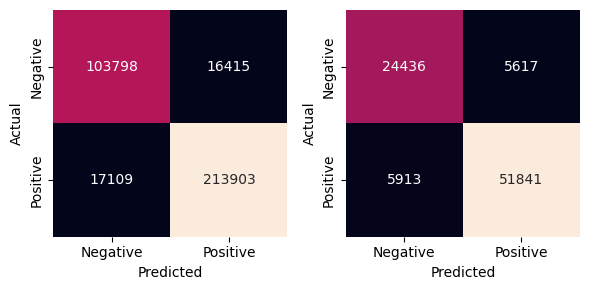

Finished in 0
2744/2744 [==============================] - 3s 1ms/step
Train
              precision    recall  f1-score   support

       False       0.85      0.84      0.85    120213
        True       0.92      0.92      0.92    231012

    accuracy                           0.89    351225
   macro avg       0.88      0.88      0.88    351225
weighted avg       0.89      0.89      0.89    351225

Test
              precision    recall  f1-score   support

       False       0.81      0.80      0.81     30053
        True       0.90      0.90      0.90     57754

    accuracy                           0.87     87807
   macro avg       0.85      0.85      0.85     87807
weighted avg       0.87      0.87      0.87     87807



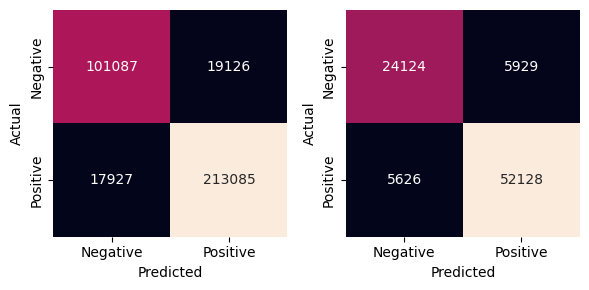

Finished in 0


In [48]:
for model_name, model, X_name, X_train_vectorized, X_test_vectorized in model_data_list:
    dl_performance(model_name, model, X_name, X_train_vectorized.toarray(), X_test_vectorized.toarray(), y_train, y_test, threshold = 0.6)